In [1]:
import pandas as pd

# Load data from CSV file
data = pd.read_csv('../../DATASET/QCG.csv')

# Preprocess data
# Covert volume from string to number
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Apply convert_volume_to_number function to Volume column
data["Volume"] = data["Volume"].apply(convert_volume_to_number)

# Covert change % from string to number
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Apply convert_change_to_number function to Change % column
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Function to convert string to number
def convert_str_to_number(str):
    return float(str.replace(',', ''))


# Apply convert_str_to_number function to Close, Open, High, Low columns
data['Close'] = data['Close'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)
data

,Date,Close,Open,High,Low,Volume,Change %
0,1/3/2024,9160.0,9170.0,9170.0,9070.0,470600,0.0033
1,29/02/2024,9130.0,9200.0,9200.0,9070.0,544100,-0.0076
2,28/02/2024,9200.0,9200.0,9210.0,9040.0,582600,0.0000
3,27/02/2024,9200.0,8920.0,9300.0,8870.0,800300,0.0268
4,26/02/2024,8960.0,8990.0,9000.0,8510.0,444100,-0.0033
...,...,...,...,...,...,...,...
1247,7/3/2019,5370.0,5250.0,5370.0,5200.0,736850,0.0697
1248,6/3/2019,5020.0,4700.0,5020.0,4640.0,2430000,0.0681
1249,5/3/2019,4700.0,4700.0,4750.0,4620.0,1040000,-0.0188
1250,4/3/2019,4790.0,4700.0,4790.0,4600.0,1200000,-0.0021


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [3]:
df = data
df = df[['Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [4]:
import sys, os
try:
    import pdarima as pda
except:
    os.system("pip install pmdarima")

from pmdarima.arima import auto_arima

In [5]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12838.135, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12909.960, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12835.815, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12839.173, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12908.015, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12837.728, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12837.714, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12836.924, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=12833.858, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=12835.772, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=12835.768, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=12837.216, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=12834.957, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.325 seconds


ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [6]:
# 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [7]:
# Predict the closing prices for the next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[6515.82261306 6523.23158356 6525.35734999 6525.96727048 6526.1422676
 6526.19247741 6526.2068835  6526.21101687 6526.21220281 6526.21254307
 6526.2126407  6526.21266871 6526.21267675 6526.21267906 6526.21267972
 6526.21267991 6526.21267996 6526.21267998 6526.21267998 6526.21267998
 6526.21267998 6526.21267999 6526.21267999 6526.21267999 6526.21267999
 6526.21267999 6526.21267999 6526.21267999 6526.21267999 6526.21267999]


In [8]:
# Convert y_val and y_test to numeric
y_val = pd.to_numeric(y_val, errors='coerce')
y_test = pd.to_numeric(y_test, errors='coerce')

# Calculate RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 1592.4840924924824
Testing RMSE: 1830.8334401476438


Validation RMSE: 1592.4840924924824
Testing RMSE: 1830.8334401476438


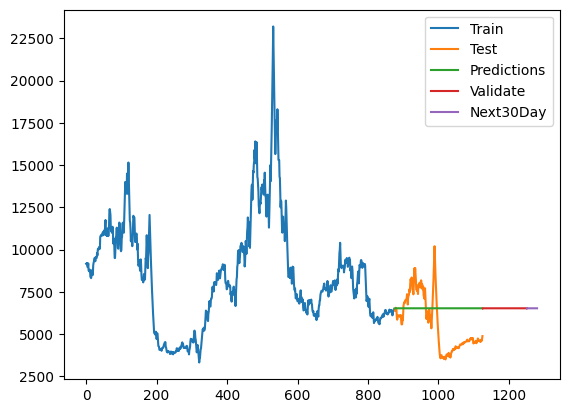

In [9]:
# Calculate RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# Plot the data
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [10]:
test_data.index

RangeIndex(start=876, stop=1126, step=1)

In [11]:
# Calculate MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Calculate MAPE, RMSE and MDA
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val) ** 2))
test_rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
valid_mape = calculate_mape(y_val, y_pred_val)
test_mape = calculate_mape(y_test, y_pred)
valid_mda = calculate_mda(y_val, y_pred_val)
test_mda = calculate_mda(y_test, y_pred)

# Print the performance metrics
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 1592.4840924924824
Testing RMSE: 1830.8334401476438
Validation MAPE: 31.47852018396828
Testing MAPE: 34.00711773966976
Validation MDA: 18.4
Testing MDA: 11.646586345381527
